# Network model proof of concept

Run a simple simulation of the learning phase of the task for one participant. Train the model with an input of the presented items and an output of the presented items + their corresponding item type (A, B, C). Then, simulate the display task by presenting the patterns of individual items

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS
import tensorflow as tf
from tensorflow.keras import layers

module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)
from nireact import task

fig_dir = '/Users/morton/Dropbox/work/mistr/figs2/net'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

## Load study-phase learning schedule

Load the study schedule for one sample participant and select a learning phase (blocked or intermixed) to simulate.

In [2]:
# read the study-phase data for one subject; for visualization
# purposes, remap item number to be in triad, item_type order
subj_dir = '/Users/morton/work/mistr/mistr_02/behav/log'
log = task.read_study(subj_dir)

block = log.loc[log.train_type == 1]
inter = log.loc[log.train_type == 2].reset_index()

# select the phase to use for simulation (performance is similar)
study = inter

In [3]:
# get the mean number of trials between within-triad 
# gaps (AB to BC) and between-triad gaps
gap = np.array([np.diff(np.nonzero(inter.triad.values == i)[0]) for i in range(7, 13)])
within = np.mean(gap[:, ::2])
between = np.mean(gap[:, 1::2])
print(f'within-triad gap:  {within:.2f}')
print(f'between-triad gap: {between:.2f}')

within-triad gap:  4.89
between-triad gap: 7.12


## Create model inputs and outputs for simulation

Simulate each trial by presenting item pairs and training to predict the same items + item type.

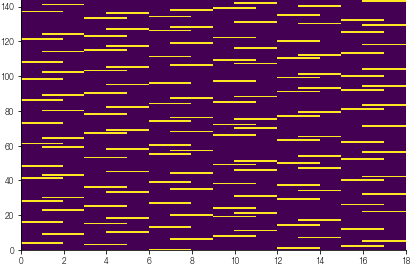

In [4]:
# make patterns for each trial indicating studies pairs
trial_item = task.pair_item_patterns(study)
fig, ax = plt.subplots()
h = ax.pcolor(trial_item)

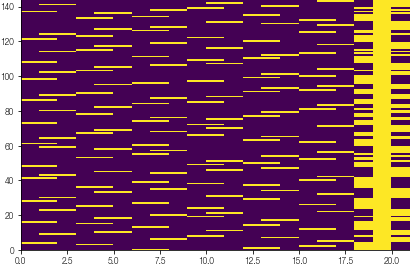

In [5]:
# make output patterns (same, but with added item type)
trial_itemtype = task.pair_itemtype_patterns(study)
trial_conj = np.hstack((trial_item, trial_itemtype))
fig, ax = plt.subplots()
h = ax.pcolor(trial_conj)

## Create a backpropagation network

The network has an input layer, one hidden layer, and an output layer.

In [32]:
# create a three-layer network
n_input = trial_item.shape[1]
n_output = trial_conj.shape[1]
model = tf.keras.Sequential([
    layers.Dense(n_input, activation='relu', input_shape=(n_input,)),
    layers.Dense(12, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(l=1)),
    layers.Dense(n_output, activation='softmax')
])

# compile the network with standard settings
optimizer=tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 'binary_crossentropy'])

## Simulate the study and display tasks

This is run many times to allow the model to converge. This isn't very realistic, but it's necessary for such as simple model to be able to learn this task well. A more realistic model would look more like the hippocampus and include recurrence to facilitate fast, pattern-separated learning.

After training, simulate the display task by presenting each item pattern and observing the resulting effect on the hidden layer.

In [33]:
# fit the model by training it to produce the output patterns
history = model.fit(trial_item, trial_conj, epochs=1000, 
                    shuffle=False, verbose=0)

# present individual item patterns to the trained network
label_indiv = np.eye(trial_item.shape[1])

# output layer
result = model.predict(label_indiv)

# hidden layer
model.pop()
hidden = model.predict(label_indiv)

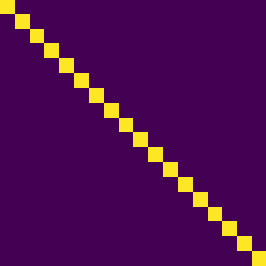

In [34]:
fig, ax = plt.subplots()
ax.matshow(label_indiv)
h = ax.axis('off')
fig.savefig(os.path.join(fig_dir, 'net_conj_input.pdf'))

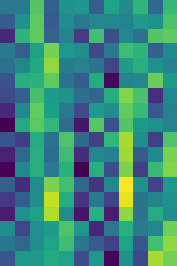

In [35]:
fig, ax = plt.subplots()
ax.matshow(hidden)
h = ax.axis('off')
fig.savefig(os.path.join(fig_dir, 'net_conj_hidden.pdf'))

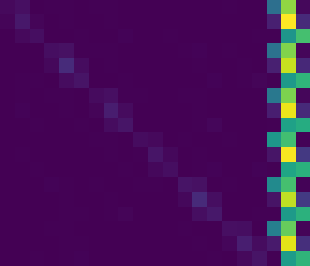

In [36]:
fig, ax = plt.subplots()
ax.matshow(result)
h = ax.axis('off')
fig.savefig(os.path.join(fig_dir, 'net_conj_output.pdf'))

## Analyze hidden layer representations

Filter the hidden layer representations to get just A and C items (to match the neural analysis). Then use MDS to project the representation into two dimensions for visualization.

/Users/morton/anaconda3/envs/mistr/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


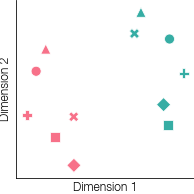

In [37]:
# get just AC items
df_item = task.task_items(6, 1)
include = np.isin(df_item.item_type, [1, 3])
hidden_ac = hidden[include, :]

# run MDS
embedding = MDS(n_components=2)
mdsfit = embedding.fit_transform(hidden_ac)

# place item information and MDS projection in dataframe
mdsdf = pd.DataFrame({'Dimension 1': mdsfit[:, 0], 
                      'Dimension 2': mdsfit[:, 1]})
df_full = pd.concat((mdsdf, df_item.loc[include, :].reset_index()), axis=1)

# plot with triads and item type labeled
fig, ax = plt.subplots(figsize=(3, 3));
ax = sns.scatterplot(x='Dimension 1', y='Dimension 2',
                     hue='item_type', style='triad', 
                     data=df_full, s=100, 
                     palette=sns.color_palette("husl", 2));
ax.get_legend().remove()
ax.set_xticks([])
ax.set_yticks([])
ax.axis('equal');
fig.savefig(os.path.join(fig_dir, 'net_conj_mds.pdf'))

## Make input/output schematic

Produce the same patterns as in the simulations, but in sorted order for visualization.

In [12]:
# create patterns in sorted order for visualization
pairs = task.task_pairs(6, 1)
label_item = task.pair_item_patterns(pairs)
label_itemtype = task.pair_itemtype_patterns(pairs)
label_conj = np.hstack((label_item, label_itemtype))

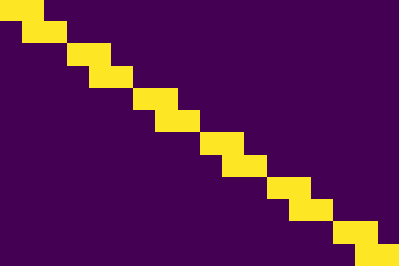

In [13]:
fig, ax = plt.subplots()
h = ax.matshow(label_item)
h = ax.axis('off')
fig.savefig(os.path.join(fig_dir, 'net_inputs.pdf'))

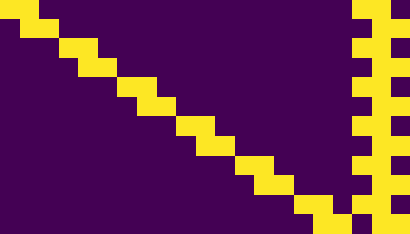

In [14]:
fig, ax = plt.subplots()
h = ax.matshow(label_conj)
h = ax.axis('off')
fig.savefig(os.path.join(fig_dir, 'net_outputs.pdf'))